# 허깅페이스 데이터셋 라이브러리 다운로드

In [ ]:
!pip3 install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.0 MB/s eta 0:00:00


# 필요 라이브러리 import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import pandas as pd

# 시드 고정

In [ ]:
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
SEED=42
seed_everything(SEED=SEED)

# 데이터프레임 설계 및 시각화

In [ ]:
repository_id = "StockLlama/ETH-USD-2022-01-01_2024-08-30"
data = load_dataset(repository_id, split = 'train')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/313 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/716 [00:00<?, ? examples/s]

In [ ]:
# 2022년 1월 1일부터 2024년 8월 30일까지의 datetime을 리스트로 만들기
date = [datetime(2022, 1, 2) + timedelta(days=i) for i in range(972)]

# 2022년 1월 1일부터 2024년 8월 30일까지의 가격을 리스트로 만들기
dataset = []

for i in range(len(data[0]['input_ids'])): # 첫번째 input_ids의 값을 float으로 만들어 리스트에 넣기
  dataset.append(float(data[0]['input_ids'][i]))

for i in range(len(data)):
    dataset.append(float(data[i]['label'])) # 이후에 label값들을 전부 리스트에 넣기

df = pd.DataFrame({ #데이터프레임 생성
    'Date': date,
    'Value': dataset
})

print(f'날짜 수 : {len(date)}, 데이터 수 : {len(dataset)}') # 데이터 개수 확인
df # 데이터프레임 출력

날짜 수 : 972, 데이터 수 : 972


,Date,Value
0,2022-01-02,91.308495
1,2022-01-03,93.061981
2,2022-01-04,91.064911
3,2022-01-05,92.021973
4,2022-01-06,84.885086
...,...,...
967,2024-08-26,61.417749
968,2024-08-27,59.431441
969,2024-08-28,52.911262
970,2024-08-29,54.952393


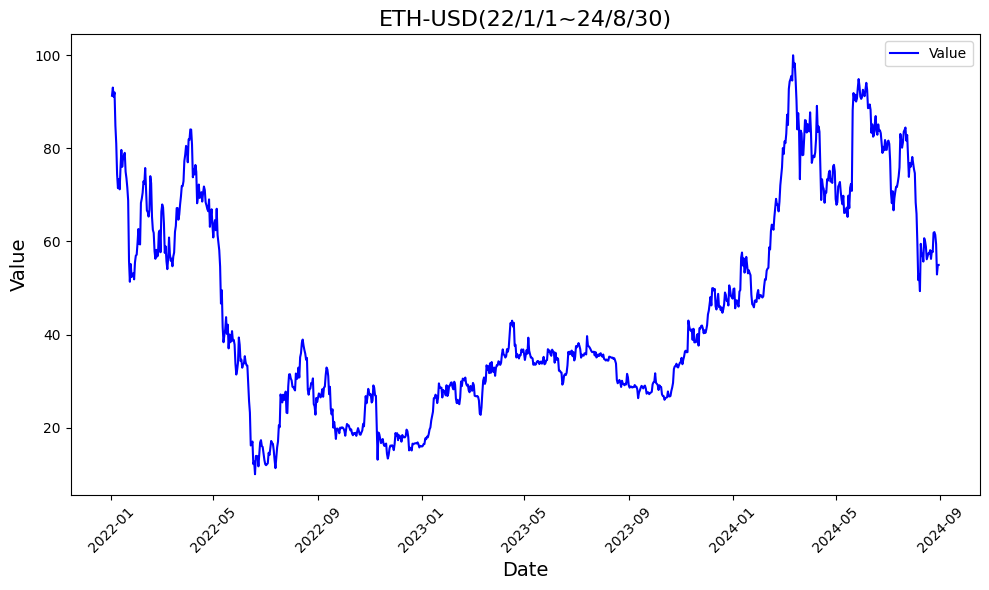

In [ ]:
# 날짜를 x축으로, 값을 y축으로 시각화
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Value'], label='Value', color='b', linestyle='-')

plt.title('ETH-USD(22/1/1~24/8/30)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
input_size = 16
output_size = 1

# log, minmaxscaler를 이용한 가격
df['Value'] = np.log1p(df['Value'])  # 로그 변환 후
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Value'] = scaler.fit_transform(df[['Value']])  # MinMaxScaler 적용

def make_dataset(data, input_size, output_size):
    X, y = [], []
    for i in range(len(data) - input_size - output_size + 1):
        X.append(data[i:i + input_size, 1].astype(float))
        y.append(data[i + input_size:i + input_size + output_size, 1].astype(float))  # y는 그 다음 기간의 값들
    return np.array(X), np.array(y)



In [ ]:
X, y = make_dataset(df.values, input_size, output_size)

# X를 [samples, features, time_steps]로 차원변환
X = X.reshape(X.shape[0], 1, X.shape[1])

# 80% 훈련, 10% 검증, 10% 테스트 데이터로 분리
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# 텐서로 변환
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

# 텐서를 이용해 데이터로더 생성
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# RNN모델 설계

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        rnn_out, hn = self.rnn(x)
        predictions = self.fc(rnn_out[:, -1, :])
        return predictions

# LSTM모델 설계

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1, :])
        return predictions

# GRU모델 설계

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(GRU, self).__init__()

        self.gru = nn.GRU(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        gru_out, hn = self.gru(x)
        predictions = self.fc(gru_out[:, -1, :])
        return predictions

# 입출력 차원 확인

In [ ]:
model = RNN(input_size=input_size, hidden_layer_size=64, output_size = output_size)

for X_batch, y_batch in train_loader:
    # X_batch = X_batch.permute(0, 2, 1)
    print(f'입력차원 : {X_batch.shape}')
    y_pred = model(X_batch)
    print(f'출력차원 : {y_pred.shape}')



    # print(f'출력값 : {y_pred}, 정답값 : {y_batch}')
    print(f'출력값 : {y_pred - y_batch}')
    break

입력차원 : torch.Size([32, 1, 16])
출력차원 : torch.Size([32, 1])
출력값 : tensor([[-0.6649],
        [-0.2065],
        [-0.3398],
        [-0.3606],
        [-0.2868],
        [-0.9545],
        [-0.1391],
        [-0.2997],
        [-0.3231],
        [-0.0650],
        [-0.3375],
        [-0.8058],
        [-0.9027],
        [ 0.2592],
        [-0.0724],
        [-0.1541],
        [-0.3372],
        [-0.1143],
        [-0.2231],
        [ 0.4548],
        [ 0.4509],
        [-0.1075],
        [ 0.1415],
        [-0.5371],
        [-0.1104],
        [-0.6090],
        [-0.7232],
        [ 0.4824],
        [-0.2051],
        [ 0.2273],
        [-0.3461],
        [ 0.3790]], grad_fn=<SubBackward0>)


# 학습 코드 작성

In [ ]:
def metric(y_pred, y_true): # 100 - SMAPE값 (y_true + y_pred값이 너무 작은 경우 result가 음수가 될 수 있으므로 그때는 0이라고 판단한다.)
    result = 100 - np.mean(2 * np.abs(np.abs(y_true) - np.abs(y_pred)) / np.abs((np.abs(y_true) + np.abs(y_pred)))) * 100
    return 0 if result < 0 else result

In [ ]:
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            y_val_pred = model(X_val)
            loss_val = criterion(y_val_pred, y_val)

            val_loss += loss_val.item()
            val_acc += metric(y_val_pred.detach().numpy(), y_val.detach().numpy())

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    return val_loss, val_acc

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()
    train_accs, train_losses = [], []
    val_accs, val_losses = [], []

    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += metric(y_pred.detach().numpy(), y_batch.detach().numpy())

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        val_loss, val_acc = validate(model, val_loader, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")

    return train_losses, train_accs, val_losses, val_accs

In [ ]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    num_batches_test = len(test_loader)

    with torch.no_grad():
        for X_test, y_test in test_loader:
            y_test_pred = model(X_test)
            loss_test = criterion(y_test_pred, y_test)

            test_loss += loss_test.item()
            test_acc += metric(y_test_pred.detach().numpy(), y_test.detach().numpy())

    test_loss /= num_batches_test
    test_acc /= num_batches_test

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    return test_loss, test_acc

# 시각화 코드

In [ ]:
def predict(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            predictions.append(y_pred.numpy())
            actuals.append(y_batch.numpy())
    return np.concatenate(predictions), np.concatenate(actuals)


def train_visualize(train_losses, train_accs, val_losses, val_accs):

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, train_losses, label="Train Loss", marker='o', linestyle='-')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='s', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, train_accs, label="Train Accuracy", marker='o', linestyle='-')
    plt.plot(epochs, val_accs, label="Validation Accuracy", marker='s', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


def predict_visualize(y_actual, y_pred):
    plt.figure(figsize=(10, 5))
    plt.plot(y_actual, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.show()

def predict_all_visualize(y_actual, pred1, pred2, pred3):
    plt.figure(figsize=(10, 5))
    plt.plot(y_actual, label="Actual")
    plt.plot(pred1, label="RNN")
    plt.plot(pred2, label="LSTM")
    plt.plot(pred3, label="GRU")
    plt.title("RNN vs LSTM vs GRU")
    plt.legend()
    plt.show()

# 하이퍼파라미터 설정 및 실험

In [ ]:
criterion = nn.MSELoss()
lr = 0.0006
epochs = 50

Epoch [1/50], Train Loss: 0.0439, Train Acc: 39.67%, Validation Loss: 0.0078, Validation Acc: 91.70%
Epoch [2/50], Train Loss: 0.0178, Train Acc: 59.75%, Validation Loss: 0.0133, Validation Acc: 87.64%
Epoch [3/50], Train Loss: 0.0143, Train Acc: 62.27%, Validation Loss: 0.0084, Validation Acc: 90.86%
Epoch [4/50], Train Loss: 0.0120, Train Acc: 64.54%, Validation Loss: 0.0089, Validation Acc: 90.09%
Epoch [5/50], Train Loss: 0.0100, Train Acc: 66.98%, Validation Loss: 0.0086, Validation Acc: 90.02%
Epoch [6/50], Train Loss: 0.0086, Train Acc: 68.56%, Validation Loss: 0.0068, Validation Acc: 91.25%
Epoch [7/50], Train Loss: 0.0076, Train Acc: 69.25%, Validation Loss: 0.0048, Validation Acc: 92.92%
Epoch [8/50], Train Loss: 0.0069, Train Acc: 69.73%, Validation Loss: 0.0056, Validation Acc: 92.08%
Epoch [9/50], Train Loss: 0.0065, Train Acc: 70.95%, Validation Loss: 0.0050, Validation Acc: 92.50%
Epoch [10/50], Train Loss: 0.0061, Train Acc: 72.31%, Validation Loss: 0.0062, Validation A

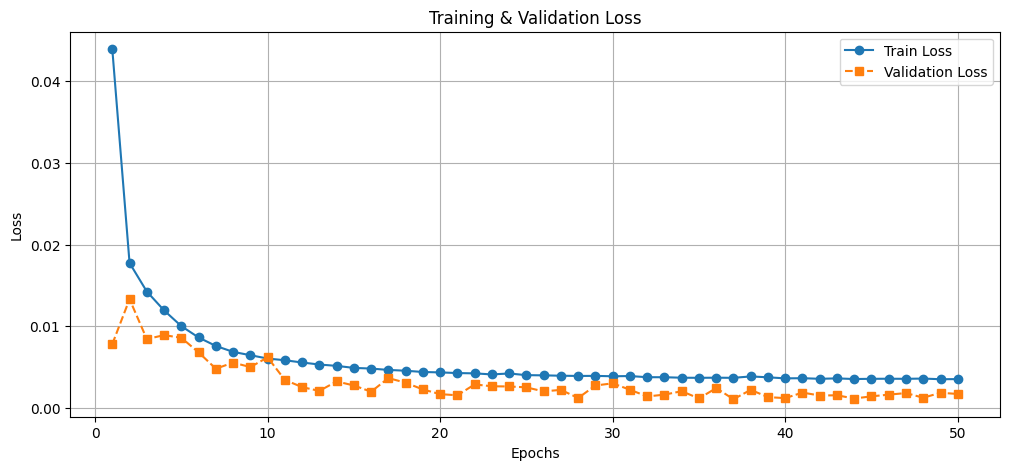

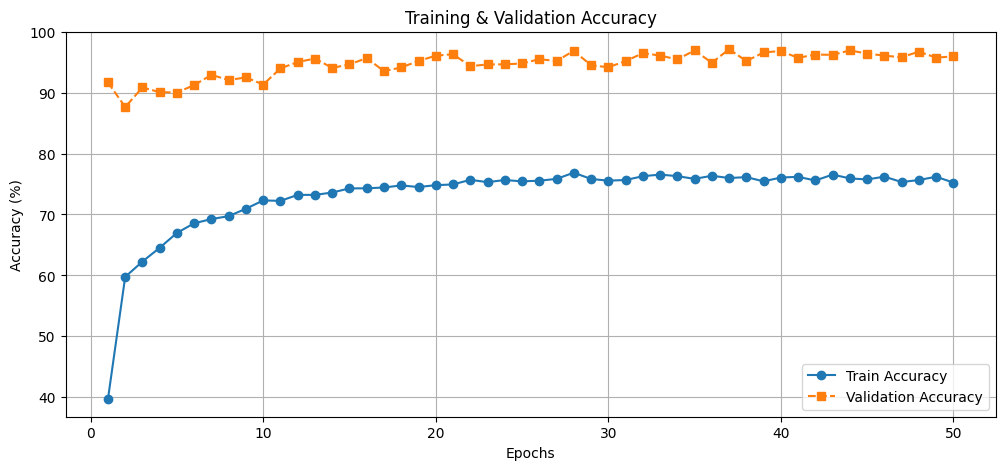

Test Loss: 0.0011, Test Accuracy: 96.13%


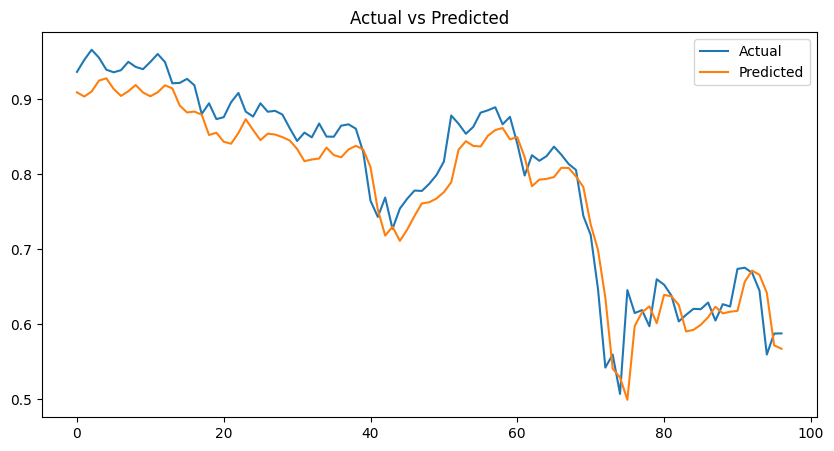

In [ ]:
rnn = RNN(input_size=input_size, hidden_layer_size=64, output_size = output_size)

optimizer = optim.Adam(rnn.parameters(), lr=lr)

rnn_t_loss, rnn_t_acc, rnn_v_loss, rnn_v_acc = train(rnn, train_loader, val_loader, criterion, optimizer, epochs=epochs)

train_visualize(rnn_t_loss, rnn_t_acc, rnn_v_loss, rnn_v_acc)

rnn_t_loss, rnn_t_acc = test(rnn, test_loader, criterion)

rnn_pred, rnn_actual = predict(rnn, test_loader)

predict_visualize(rnn_actual, rnn_pred)

Epoch [1/50], Train Loss: 0.1099, Train Acc: 8.76%, Validation Loss: 0.2315, Validation Acc: 20.48%
Epoch [2/50], Train Loss: 0.0536, Train Acc: 34.27%, Validation Loss: 0.0442, Validation Acc: 73.04%
Epoch [3/50], Train Loss: 0.0289, Train Acc: 49.89%, Validation Loss: 0.0108, Validation Acc: 89.90%
Epoch [4/50], Train Loss: 0.0196, Train Acc: 57.42%, Validation Loss: 0.0099, Validation Acc: 90.41%
Epoch [5/50], Train Loss: 0.0169, Train Acc: 58.03%, Validation Loss: 0.0074, Validation Acc: 92.05%
Epoch [6/50], Train Loss: 0.0157, Train Acc: 58.38%, Validation Loss: 0.0069, Validation Acc: 92.32%
Epoch [7/50], Train Loss: 0.0147, Train Acc: 59.39%, Validation Loss: 0.0062, Validation Acc: 92.76%
Epoch [8/50], Train Loss: 0.0138, Train Acc: 60.45%, Validation Loss: 0.0058, Validation Acc: 93.03%
Epoch [9/50], Train Loss: 0.0128, Train Acc: 61.74%, Validation Loss: 0.0063, Validation Acc: 92.61%
Epoch [10/50], Train Loss: 0.0119, Train Acc: 62.83%, Validation Loss: 0.0053, Validation Ac

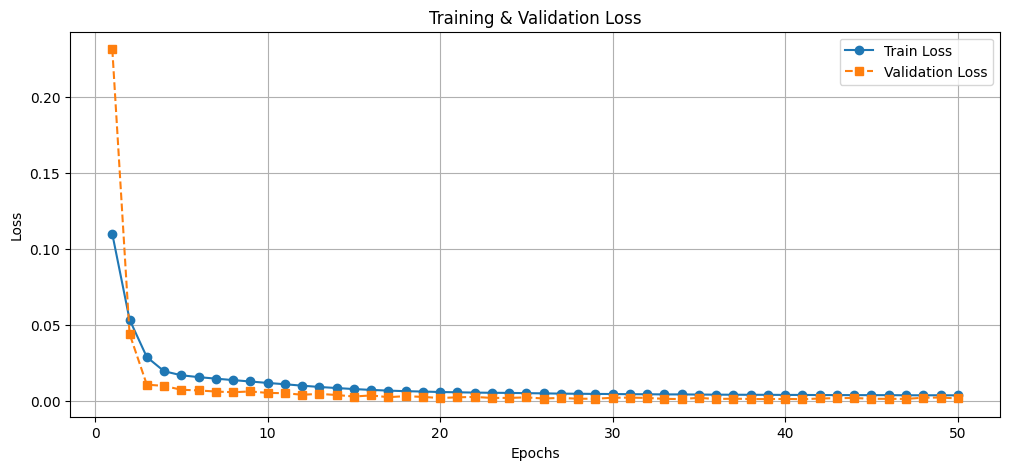

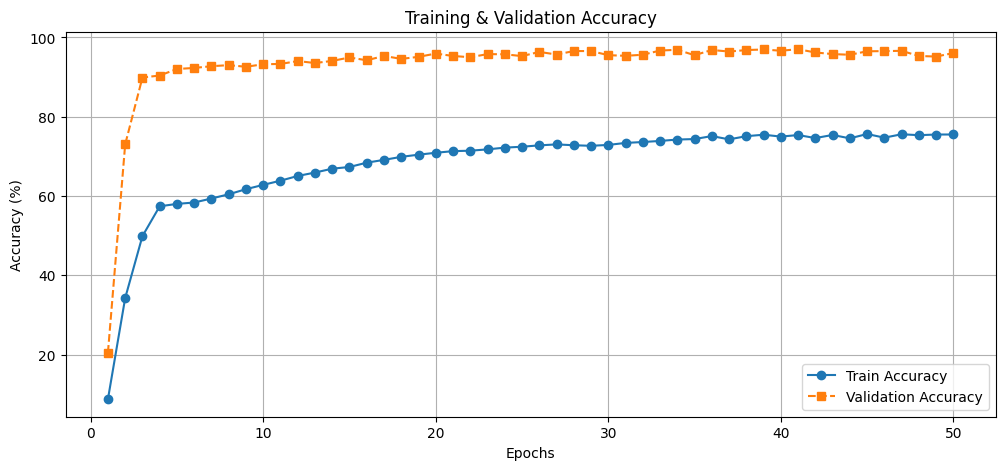

Test Loss: 0.0011, Test Accuracy: 96.59%


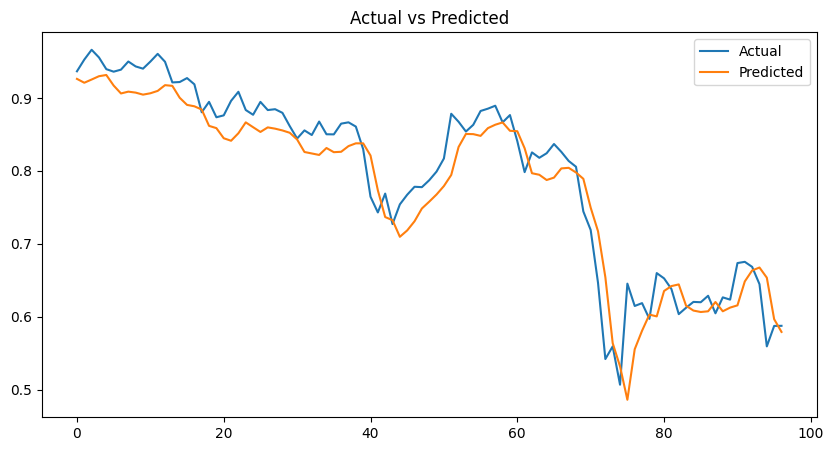

In [ ]:
lstm = LSTM(input_size=input_size, hidden_layer_size=64, output_size = output_size)

optimizer = optim.Adam(lstm.parameters(), lr=lr)

lstm_t_loss, lstm_t_acc, lstm_v_loss, lstm_v_acc = train(lstm, train_loader, val_loader, criterion, optimizer, epochs=epochs)

train_visualize(lstm_t_loss, lstm_t_acc, lstm_v_loss, lstm_v_acc)

lstm_t_loss, lstm_t_acc = test(lstm, test_loader, criterion)

lstm_pred, lstm_actual = predict(lstm, test_loader)

predict_visualize(lstm_actual, lstm_pred)

Epoch [1/50], Train Loss: 0.0629, Train Acc: 27.34%, Validation Loss: 0.0545, Validation Acc: 69.30%
Epoch [2/50], Train Loss: 0.0237, Train Acc: 54.81%, Validation Loss: 0.0069, Validation Acc: 92.45%
Epoch [3/50], Train Loss: 0.0181, Train Acc: 59.40%, Validation Loss: 0.0105, Validation Acc: 90.02%
Epoch [4/50], Train Loss: 0.0161, Train Acc: 59.41%, Validation Loss: 0.0075, Validation Acc: 91.93%
Epoch [5/50], Train Loss: 0.0146, Train Acc: 61.22%, Validation Loss: 0.0071, Validation Acc: 92.10%
Epoch [6/50], Train Loss: 0.0131, Train Acc: 62.49%, Validation Loss: 0.0057, Validation Acc: 92.93%
Epoch [7/50], Train Loss: 0.0118, Train Acc: 64.01%, Validation Loss: 0.0046, Validation Acc: 93.70%
Epoch [8/50], Train Loss: 0.0106, Train Acc: 65.13%, Validation Loss: 0.0041, Validation Acc: 93.99%
Epoch [9/50], Train Loss: 0.0094, Train Acc: 66.28%, Validation Loss: 0.0042, Validation Acc: 93.89%
Epoch [10/50], Train Loss: 0.0084, Train Acc: 67.22%, Validation Loss: 0.0029, Validation A

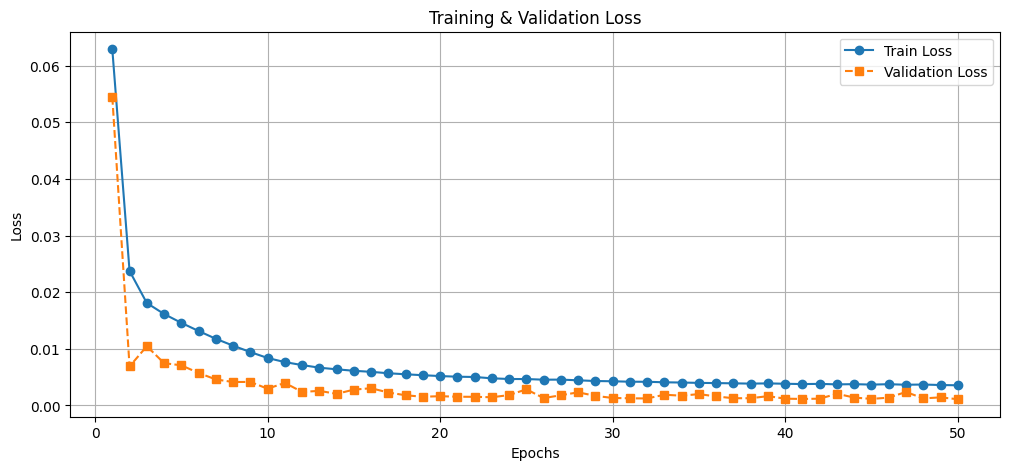

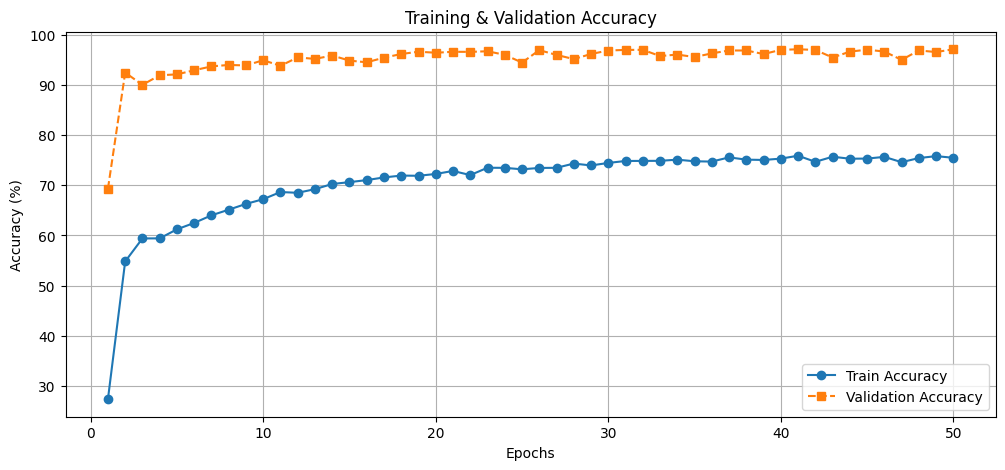

Test Loss: 0.0009, Test Accuracy: 97.53%


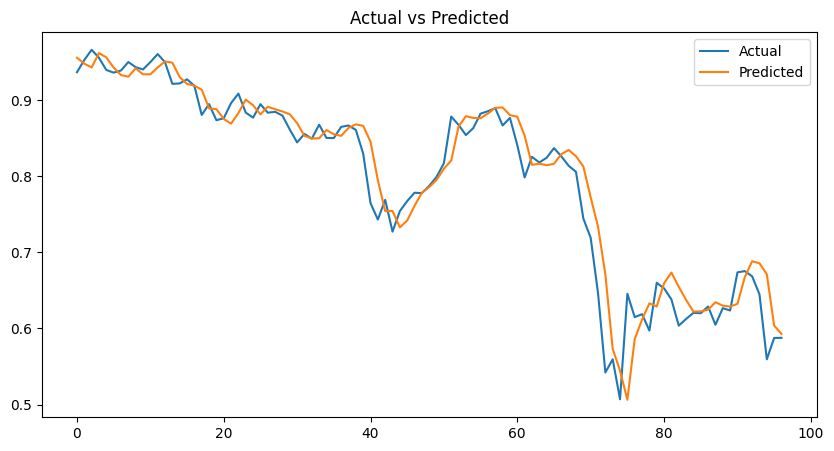

In [ ]:

gru = GRU(input_size=input_size, hidden_layer_size=64, output_size = output_size)

optimizer = optim.Adam(gru.parameters(), lr=lr)

gru_t_loss, gru_t_acc, gru_v_loss, gru_v_acc = train(gru, train_loader, val_loader, criterion, optimizer, epochs=epochs)

train_visualize(gru_t_loss, gru_t_acc, gru_v_loss, gru_v_acc)

gru_t_loss, gru_t_acc = test(gru, test_loader, criterion)

gru_pred, gru_actual = predict(gru, test_loader)

predict_visualize(gru_actual, gru_pred)

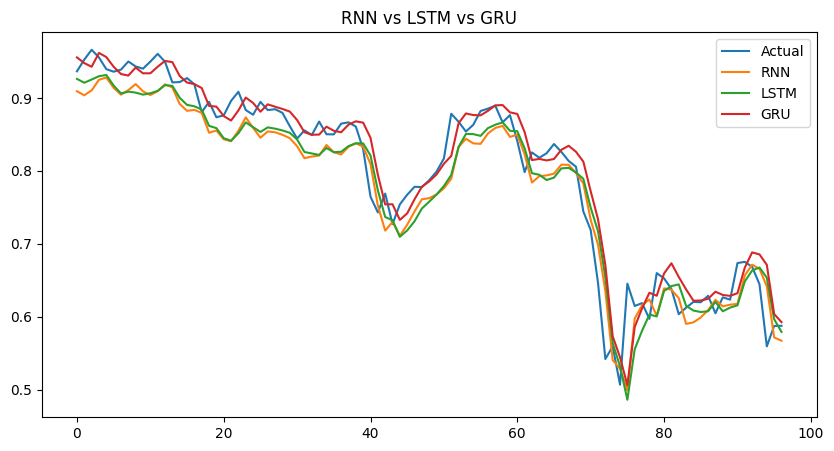

In [ ]:
predict_all_visualize(rnn_actual, rnn_pred, lstm_pred, gru_pred)

# 보고서

## 1. 요약

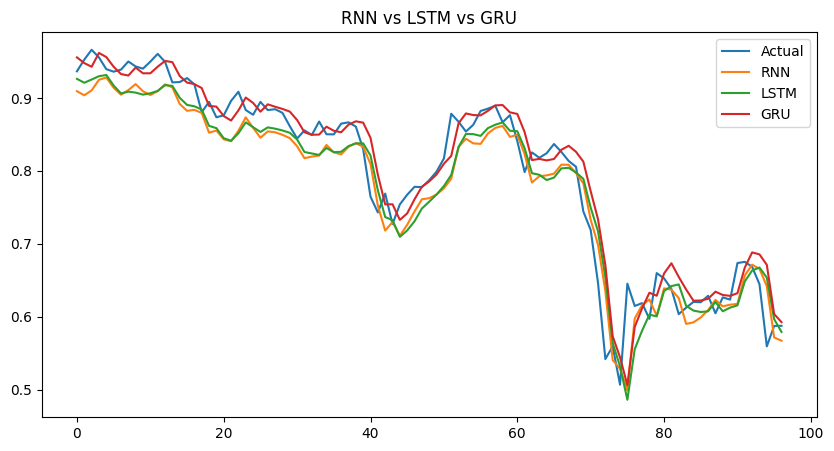

RNN, LSTM, GRU를 통해 이더리움 가격 시계열 데이터를 학습시키고 실제 가격과 비교하여 시각화를 하였을 때, 전체적으로 비슷한 결과를 보였지만 GRU(97.53%), LSTM(96.59%), RNN(96.13%) 순으로 높은 정확도를 보였다

## 2. 데이터셋(StockLlama/ETH-USD-2022-01-01_2024-08-30)

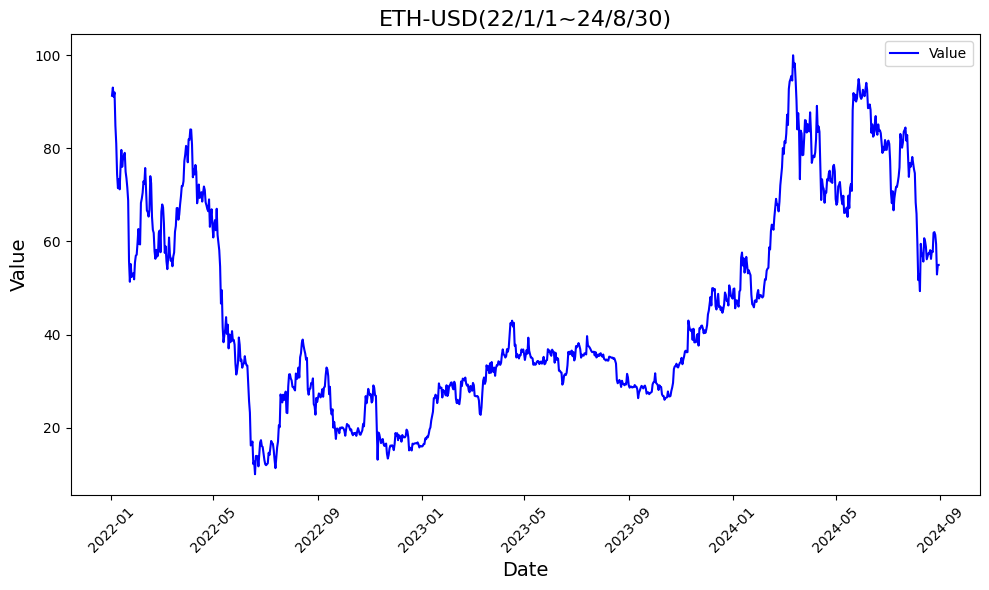

데이터셋 링크 : https://huggingface.co/datasets/StockLlama/ETH-USD-2022-01-01_2024-08-30

이 데이터셋은 2022년 1월 1일부터 2024년 8월 31일까지의 이더리움/달러 간 환율 데이터이다.

데이터는 256일 간의 이전 환율 값 시퀀스인 input data와 그 다음 1일의 환율 데이터로 이루어져 있으며, 총 716개의 데이터셋이 있다.

즉 716 + 256 = 972개의 환율 값 시퀀스로 이루어진 데이터셋이라고 볼 수 있다.

이러한 시계열 데이터를 통해 환율의 가격, 변동성을 예측할 수 있다.

## 3. 실험 과정

- 커스텀 데이터셋 제작

  이 데이터는 input이 256개의 시퀀스 데이터, output이 1개인 데이터이지만, 직접 972개의 환율 값 시퀀스로 이루어진 데이터프레임으로 만든 후 input의 크기, output의 크기를 직접 설정할 수 있도록 데이터셋을 제작하는 코드를 작성하였다.

  이후 데이터의 값을 로그 변환을 하고, 0~1의 값을 minmaxScaler를 통해 변환하여 데이터를 정규화하고자 하였다.

  과제에서는 input은 16일의 시퀀스 데이터를 이용해 이후 1일의 가격을 예측하는 데이터로 만들었다.

  또한 데이터는 train : validation : test = 80 : 10 : 10으로 나누었다.

- 데이터 전처리

  - 로그 변환

    비트코인 환율 데이터는 변동성이 크다고 생각해 변동성을 줄이고 일반적인 패턴을 학습시키고자 로그 변환을 사용하였다.

    또한 값이 갑자기 올랐다 줄어드는 이상치(outliers)의 영향을 줄이는 데에에도 영향을 미칠 것이라 생각했다.

  - MinMaxScaler

    다음 세 모델들은 활성화 함수로 tanh를 사용하고 있기 때문에 큰 값이 들어갈 경우 그래디언트 값이 0에 가까워져 학습이 되지 않을 것이라고 생각했다.
    
    그래서 입력값 분포를 -1~1의 수로 스케일 변환을 진행해 학습이 원활하게 진행하도록 하였다.

- 학습 진행
  
  epoch : 50

  Loss function : MSELoss(Minimum Square Error)

  Optimizer : Adam
  
  Leaning Rate : 0.0006

  metric(정확도 판단) : 100 - SMAPE

    - SMAPE : Symmetric Mean Absolute Percentage Error의 줄임말이며 두 값의 평균 대비 오차 비율을 계산하는 공식이다. 즉 위의 metric에서는 100 - SMAPE을 통해 정확도를 판단하고자 하였다.

  위와 같은 실험 환경으로 통제하고 RNN, LSTM, GRU 간의 학습 성능 차이를 비교해보고자 하였다.





## 4. 실험 결과

### 4-1. RNN

  - Train Loss : 0.0035
  - Train Accuracy : 75.23%
  - Validation Loss : 0.0017
  - Validation Accuracy : 95.97%
  - Test Loss : 0.0011
  - Test Accuracy : 96.13%

  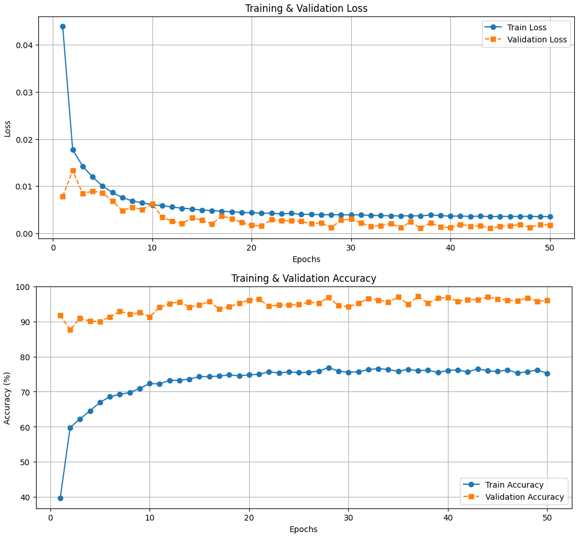

### 4-2. LSTM

  - Train Loss : 0.0037
  - Train Accuracy : 75.53%
  - Validation Loss : 0.0017
  - Validation Accuracy : 96.07%
  - Test Loss : 0.0011
  - Test Accuracy : 96.59%

  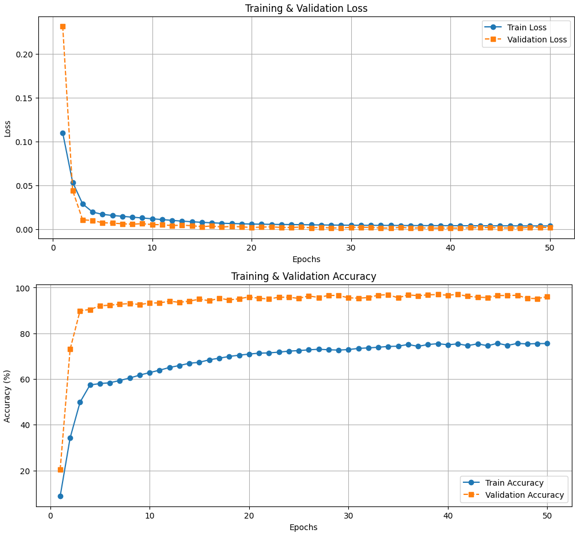

### 4-3. GRU

  - Train Loss : 0.0036
  - Train Accuracy : 75.48%
  - Validation Loss : 0.0011
  - Validation Accuracy : 97.12%
  - Test Loss : 0.0009
  - Test Accuracy : 97.53%

  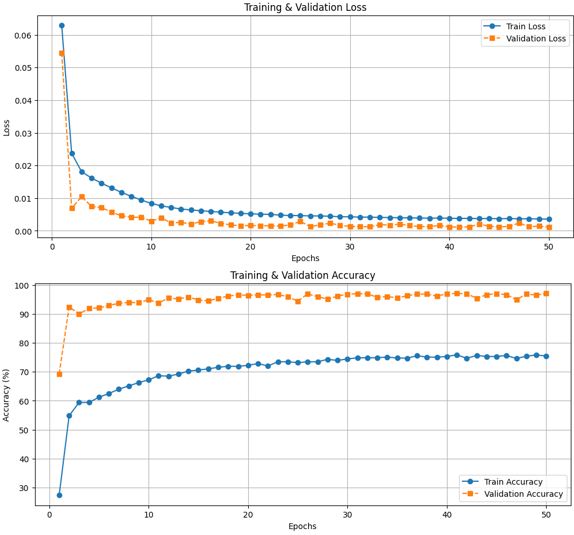

## 5. 실험 분석 및 고찰

- 결과 분석

  - 전체적으로 비슷하게 학습하는 경향을 보였지만 GRU, LSTM, RNN순으로 테스트 정확도가 높게 나왔다.
  
    RNN의 장기 문맥 의존성, 기울기 소실 문제를 해결한 LSTM과 GRU 모델이 성능이 더 높게 나오는 것을 볼 수 있다.

    또한 적은 데이터셋의 경우 더 단순한 구조의 모델인 GRU가 LSTM보다 성능이 더 높게 나올 수 있을 것이라고 추론했다.

  - 또한 각 모델의 Accuracy 그래프를 보았을 때, 학습 안정성은 LSTM, GRU, RNN 순으로 안정적으로 학습되는 것을 볼 수 있다.

    RNN의 기울기 소실로 인한 장기 문맥 의존성 문제의 해결을 위해 LSTM이 고안되었고 GRU는 LSTM의 계산량을 줄이면서 유사한 성능을 내기 위해 만들어진 모델인 만큼 LSTM보다 학습 안정성이 떨어질 가능성이 높아 이러한 결과가 나타났다고 생각한다.

- 결과 고찰

  - 전체적으로 train의 학습 결과가 validation, test의 결과보다 좋지 않게 나와있다.
    
    log, MinMaxScaler를 이용해 scale조정을 하여 데이터의 변화가 크지 않다고 하더라도, 데이터셋을 80 : 10 : 10으로 나누어 train데이터에 더 다양한 패턴을 가지고 있기 때문에 정확도 및 Loss값이 validation, test데이터보다 좋지 않게 나온 것으로 생각한다.
  
  - 데이터의 실제 값과 모델들의 결과를 비교하는 그래프의 모양이 실제 값과 유사한 패턴을 따르는 경향을 보인다.

    학습을 진행할 때 시퀀스 데이터를 이용해 다음 스텝의 값을 예측하는 방식으로 이루어졌기 때문에, 모델이 이전 데이터의 값을 단순하게 따라가는 방식으로 학습되었을 가능성이 있다.

  - Loss값이 매우 낮고 Accuracy값이 매우 높은 경향을 보인다.

    데이터 scale 조정과 Accuracy 측정 지표(metric)의 변화에 따라 Loss값과 Accuracy값을 다르게 측정이 가능하기 때문에, 가격을 예측하는 시계열 데이터에 대한 정형화된 측정 지표가 필요하다고 생각되었다.